<a href="https://colab.research.google.com/github/victorm0202/curso_ML_metagenomica/blob/main/notebooks/MLP_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A pytorch workflow
Adapted from [Learn PyTorch for Deep Learning.](https://github.com/mrdbourke/pytorch-deep-learning)

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" alt="a pytorch workflow flowchart" width=900/>

We will consider a **classification problem**.


| **Topic** | **Contents** |
| ----- | ----- |
| **0. Architecture of a classification neural network** | Neural networks can come in almost any shape or size, but they typically follow a similar floor plan. |
| **1. Getting binary classification data ready** | Data can be almost anything but to get started we're going to create a simple binary classification dataset. |
| **2. Building a PyTorch classification model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop** specific to classification. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Improving a model (from a model perspective)** | We've trained an evaluated a model but it's not working, let's try a few things to improve it. |
| **6. Non-linearity** | So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines? |
| **7. Replicating non-linear functions** | We used **non-linear functions** to help model non-linear data, but what do these look like? |
| **8. Putting it all together with multi-class classification** | Let's put everything we've done so far for binary classification together with a multi-class classification problem. |


## A general view of the architecture of a classification neural network

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |


## Our toy dataset

We'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots. 

In [25]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X_numpy, y_numpy = make_circles(n_samples, factor=.1, noise=.15,
                    random_state=42) # keep random state so we get the same values

In [26]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X_numpy[:, 0],
    "X2": X_numpy[:, 1],
    "label": y_numpy
})
circles.head(10)

,X1,X2,label
0,0.006243,0.140122,1
1,0.067281,0.132009,1
2,-0.207712,0.377611,1
3,-0.308114,-0.064412,1
4,0.462575,-0.885996,0
5,0.011421,0.315649,1
6,-0.019234,0.117052,1
7,0.009491,0.104513,1
8,-0.067743,-0.145844,1
9,-0.056268,1.145700,0


In [ ]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

500 each, nice and balanced.


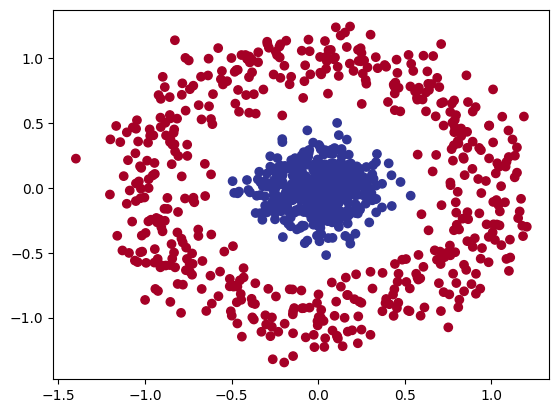

In [27]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X_numpy[:, 0], y=X_numpy[:, 1], c=y_numpy, cmap=plt.cm.RdYlBu);

### Input and output shapes

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in your models.

"What shapes are my inputs and what shapes are my outputs?"

In [ ]:
# Check the shapes of our features and labels
X_numpy.shape, y_numpy.shape

((1000, 2), (1000,))

This tells us the second dimension for `X` means it has two features (vector) where as `y` has a single feature (scalar).

We have two inputs for one output.

### Turn data into tensors and create train and test splits


In [28]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X_numpy).type(torch.float)
y = torch.from_numpy(y_numpy).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.0062,  0.1401],
         [ 0.0673,  0.1320],
         [-0.2077,  0.3776],
         [-0.3081, -0.0644],
         [ 0.4626, -0.8860]]),
 tensor([1., 1., 1., 1., 0.]))

We will use [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from Scikit-Learn (`test_size=0.2`, i.e., 80% training, 20% testing).

In [29]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop.



In [ ]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

![landscape](https://drive.google.com/uc?id=1V3Tg9uKxVfXmpXp9s86JWV2raoucbQML)


In [30]:
# neural network above:
class nnet0(nn.Module):
    def __init__(self):
        super(nnet0, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=2, out_features=5), # takes in 2 features (X), produces 5 features
            nn.Linear(in_features=5, out_features=1), # takes in 5 features, produces 1 feature (y)
        )

    def forward(self, x):
        return self.seq(x)


# Create an instance of the model and send it to target device
model_0 = nnet0().to(device)
model_0

nnet0(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

### Setup loss function and optimizer


| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Mutli-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these some common ones you'll see.*

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use? 

The [documentation for `torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. 

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()`.

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [31]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

Now let's also create an **evaluation metric**.


In [32]:
# Calculate accuracy (a classification metric)
from sklearn.metrics import accuracy_score

#def accuracy_fn(y_true, y_pred):
#    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
#    acc = (correct / len(y_pred)) * 100 
#    return acc

## Train model

Okay, now we've got a loss function and optimizer ready to go, let's train a model.

Do you remember the steps in a PyTorch training loop?

If not, here's a reminder.

Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>



### Going from raw model outputs to predicted labels


In [ ]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3750],
        [-0.3452],
        [-0.3686],
        [-0.1888],
        [-0.3947]], grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

But *what* are they?

They're the output of our `forward()` method (`nn.Linear()` layers):

$$
\mathbf{y} = x \cdot \mathbf{Weights}^T  + \mathbf{bias}
$$

The *raw outputs* (unmodified) of this equation ($\mathbf{y}$) and in turn, the raw outputs of our model are often referred to as [**logits**](https://datascience.stackexchange.com/a/31045).

To obtain probabilities, we use the [sigmoid activation function](https://pytorch.org/docs/stable/generated/torch.sigmoid.html).

In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4073],
        [0.4146],
        [0.4089],
        [0.4529],
        [0.4026]], grad_fn=<SigmoidBackward0>)

Class asignations:

* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs).squeeze()
y_preds[:5]

tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

### Building a training and testing loop

Let's start by training for 100 epochs and outputing the model's progress every 10 epochs. 

In [33]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits)) 
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_score(y_train.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_test.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69564, Accuracy: 0.50% | Test loss: 0.69721, Test acc: 0.50%
Epoch: 10 | Loss: 0.69391, Accuracy: 0.49% | Test loss: 0.69622, Test acc: 0.46%
Epoch: 20 | Loss: 0.69328, Accuracy: 0.35% | Test loss: 0.69604, Test acc: 0.33%
Epoch: 30 | Loss: 0.69304, Accuracy: 0.32% | Test loss: 0.69608, Test acc: 0.30%
Epoch: 40 | Loss: 0.69295, Accuracy: 0.35% | Test loss: 0.69616, Test acc: 0.33%
Epoch: 50 | Loss: 0.69291, Accuracy: 0.39% | Test loss: 0.69624, Test acc: 0.38%
Epoch: 60 | Loss: 0.69288, Accuracy: 0.44% | Test loss: 0.69630, Test acc: 0.40%
Epoch: 70 | Loss: 0.69287, Accuracy: 0.47% | Test loss: 0.69634, Test acc: 0.45%
Epoch: 80 | Loss: 0.69286, Accuracy: 0.49% | Test loss: 0.69637, Test acc: 0.46%
Epoch: 90 | Loss: 0.69285, Accuracy: 0.49% | Test loss: 0.69640, Test acc: 0.47%


## Make predictions and evaluate the model



In [34]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

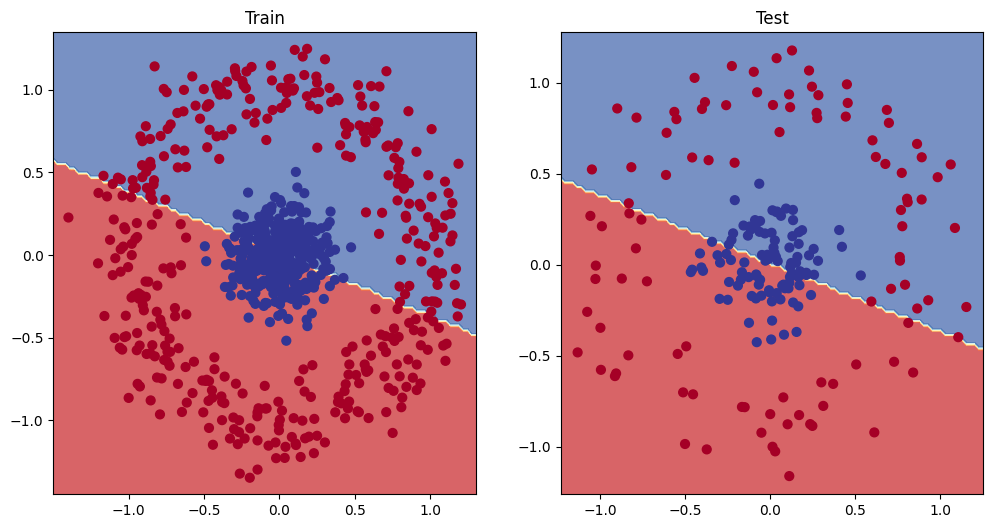

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Neural network with non-linear activation functions 




In [36]:
class nnet1(nn.Module):
    def __init__(self):
        super(nnet1, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=2, out_features=5), 
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=5), 
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1), 
        )

    def forward(self, x):
        return self.seq(x)



In [ ]:
class nnet2(nn.Module):
    def __init__(self):
        super(nnet2, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=2, out_features=20), 
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=20), 
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=10), 
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=5), 
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1), 
        )

    def forward(self, x):
        return self.seq(x)



### Training a model with non-linearity


In [37]:
X = torch.from_numpy(X_numpy).type(torch.float)
y = torch.from_numpy(y_numpy).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [38]:
# Create an instance of the model and send it to target device
model_1 = nnet1().to(device)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 1000

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_1(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits)) 
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_score(y_train.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_test.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71674, Accuracy: 0.50% | Test loss: 0.71335, Test acc: 0.50%
Epoch: 100 | Loss: 0.65523, Accuracy: 0.84% | Test loss: 0.66001, Test acc: 0.82%
Epoch: 200 | Loss: 0.47756, Accuracy: 0.88% | Test loss: 0.49087, Test acc: 0.88%
Epoch: 300 | Loss: 0.24233, Accuracy: 0.93% | Test loss: 0.25971, Test acc: 0.94%
Epoch: 400 | Loss: 0.08128, Accuracy: 1.00% | Test loss: 0.10376, Test acc: 1.00%
Epoch: 500 | Loss: 0.03882, Accuracy: 1.00% | Test loss: 0.05832, Test acc: 1.00%
Epoch: 600 | Loss: 0.02483, Accuracy: 1.00% | Test loss: 0.04163, Test acc: 1.00%
Epoch: 700 | Loss: 0.01834, Accuracy: 1.00% | Test loss: 0.03321, Test acc: 1.00%
Epoch: 800 | Loss: 0.01463, Accuracy: 1.00% | Test loss: 0.02803, Test acc: 1.00%
Epoch: 900 | Loss: 0.01223, Accuracy: 1.00% | Test loss: 0.02452, Test acc: 1.00%


### Evaluating a model trained with non-linear activation functions

Remember how our circle data is non-linear? Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [39]:
# Make predictions
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

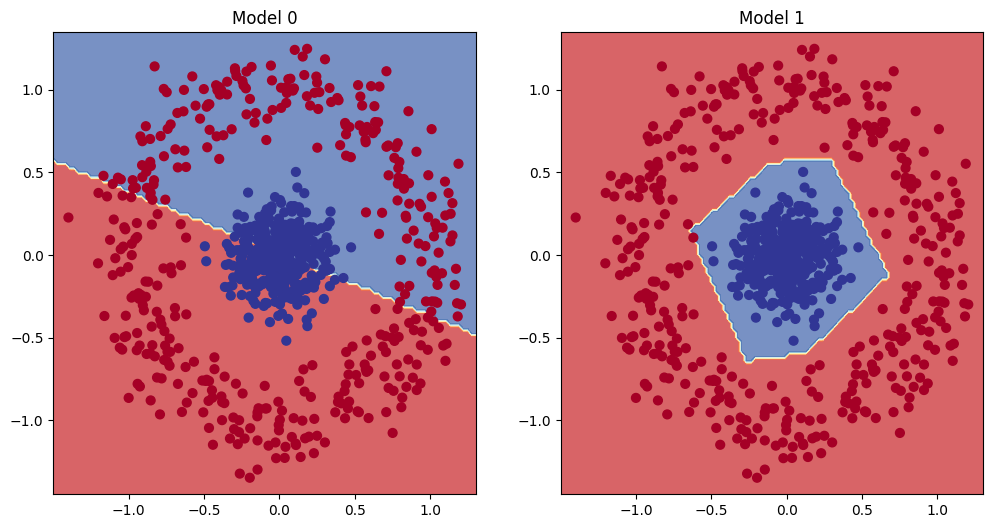

In [40]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Model 0")
plot_decision_boundary(model_0, X_train, y_train) 
plt.subplot(1, 2, 2)
plt.title("Model 1")
plot_decision_boundary(model_1, X_train, y_train) 

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

# Ejemplo OTUs

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
os.chdir('/content/drive/My Drive/Cursos/metagenomica/Notebooks/')
!pwd

/content/drive/My Drive/Cursos/metagenomica/Notebooks


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

otus = pd.read_csv("../data/OTUS_conservados.csv", index_col="X")

cont_names = list(otus.drop(["New_Labels","Latitude", "Longitude"], axis=1).columns)
y_names = ["New_Labels"]
otus_df = otus[cont_names+y_names]

In [4]:
def get_reduced_data(data,y_counts,ylab='New_Labels',n_min=20):
    y_val = y_counts[y_counts>n_min]
    data_val_df = data.loc[data[ylab].isin(y_val.index)]
    return data_val_df, y_val

In [5]:
y_counts = otus_df.New_Labels.value_counts()
#y_counts

In [17]:
n_min = 60
otus_val_df, y_val = get_reduced_data(otus_df,y_counts,'New_Labels',n_min)
otus_val_df.shape

(2583, 604)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline
#plt.style.use('seaborn') 

yy = np.array(otus_val_df[y_names]).ravel()
X_numpy = np.array(otus_val_df.drop(y_names,axis=1)).astype('float')

scaler = StandardScaler()
X_numpy = scaler.fit_transform(X_numpy)

le = preprocessing.LabelEncoder()
le.fit(yy)
#le.classes_
y_numpy = le.transform(yy)
#le.inverse_transform(y_cat[:5])

In [19]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
# Turn data into tensors
X = torch.from_numpy(X_numpy).type(torch.float)
y = torch.from_numpy(y_numpy).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [21]:
class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )

    def forward(self, x):
        return self.seq(x)


In [22]:
# Set the hyperparameters for data creation
NUM_CLASSES = len(le.classes_)
NUM_FEATURES = X_train.shape[1]

# Create an instance of the model and send it to target device
model = nnet_otus(NUM_FEATURES, NUM_CLASSES).to(device)

# Setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Fit the model
torch.manual_seed(42)
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_score(y_train.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_test.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 2.64498, Accuracy: 0.03% | Test loss: 2.63631, Test acc: 0.02%
Epoch: 10 | Loss: 2.55449, Accuracy: 0.28% | Test loss: 2.54961, Test acc: 0.27%
Epoch: 20 | Loss: 2.46373, Accuracy: 0.28% | Test loss: 2.46080, Test acc: 0.27%
Epoch: 30 | Loss: 2.34353, Accuracy: 0.28% | Test loss: 2.33737, Test acc: 0.27%
Epoch: 40 | Loss: 2.07047, Accuracy: 0.40% | Test loss: 2.03857, Test acc: 0.45%
Epoch: 50 | Loss: 1.64333, Accuracy: 0.52% | Test loss: 1.64760, Test acc: 0.49%
Epoch: 60 | Loss: 1.38431, Accuracy: 0.56% | Test loss: 1.40470, Test acc: 0.57%
Epoch: 70 | Loss: 1.17163, Accuracy: 0.69% | Test loss: 1.19048, Test acc: 0.68%
Epoch: 80 | Loss: 0.97254, Accuracy: 0.71% | Test loss: 0.99086, Test acc: 0.69%
Epoch: 90 | Loss: 0.82504, Accuracy: 0.72% | Test loss: 0.84885, Test acc: 0.70%


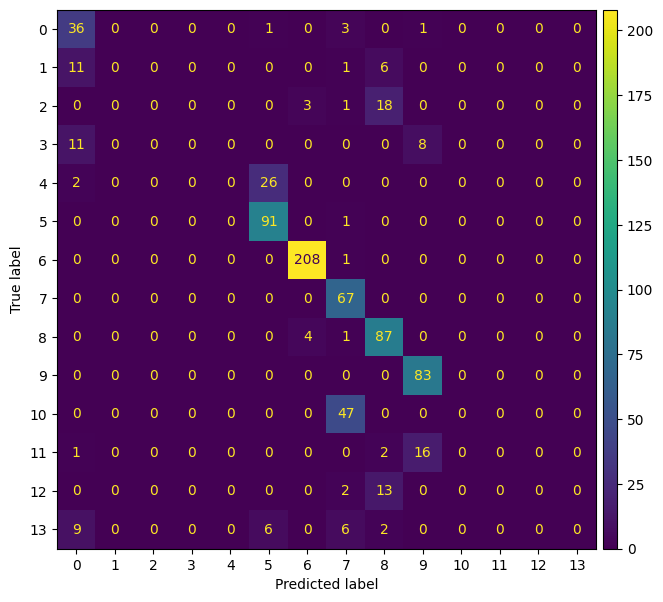

In [23]:
model.eval()
with torch.no_grad():
  test_logits = model(X_test)
  y_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [24]:
print(metrics.classification_report(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.51      0.88      0.65        41
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        28
           5       0.73      0.99      0.84        92
           6       0.97      1.00      0.98       209
           7       0.52      1.00      0.68        67
           8       0.68      0.95      0.79        92
           9       0.77      1.00      0.87        83
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        19
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00        23

    accuracy                           0.74       775
   macro avg       0.30      0.41      0.34       775
weighted avg       0.58      0.74      0.64       775



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
